In [2]:
import pystan
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import pystan
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

In [3]:
df = pd.read_csv("dataset.csv")
df

,Date,Confirmed,Daily,Hospitalizations,Deaths,Recovered,Date2,C1_School closing,C2_Workplace closing,C3_Cancel public events,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,2020-1-23,1.0,1.0,77.814000,0.0,0,20200123.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
1,2020-1-24,2.0,1.0,77.814000,0.0,0,20200124.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
2,2020-1-25,2.0,0.0,77.814000,0.0,0,20200125.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
3,2020-1-26,5.0,3.0,14.493000,0.0,0,20200126.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
4,2020-1-27,5.0,0.0,14.493000,0.0,0,20200127.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
5,2020-1-28,5.0,0.0,14.493000,0.0,0,20200128.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
6,2020-1-29,5.0,0.0,14.493000,0.0,0,20200129.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
7,2020-1-30,5.0,0.0,14.493000,0.0,0,20200130.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
8,2020-1-31,7.0,2.0,14.493000,0.0,0,20200131.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
9,2020-2-1,8.0,1.0,14.493000,0.0,0,20200201.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0


In [113]:
stan_code = """data {
  int <lower=0> T;
  vector[T] x;
  vector[T] y;
  
  int<lower=0> T_new;
  vector[T_new] x_new;
}

parameters {
  vector[T+T_new] u_err; //Slope innovation
  vector[T+T_new] v_err; //Level innovation
  real beta;
  real <lower=0> s_obs;
  real <lower=0> s_slope;
  real <lower=0> s_level;
}

transformed parameters {
  vector[T] u; //Level
  vector[T] v; //Slope
  u[1] = u_err[1];
  v[1] = v_err[1];
  for (t in 2:T) {
    u[t] = u[t-1] + v[t-1] + s_level * u_err[t];
    v[t] = v[t-1] + s_slope * v_err[t];
  }
}

model {
  u_err ~ normal(0,1);
  v_err ~ normal(0,1);
  y ~ normal (u + beta*x, s_obs);
}

generated quantities {
  vector[T_new] y_new;
  vector[T+T_new] u_new;
  vector[T+T_new] v_new;
  
  u_new[1:T] = u;
  v_new[1:T] = v;

  for (n in 1:T_new) {
    u_new[T+n] = u_new[T+n-1] + v_new[T+n-1] + s_level * u_err[T+n];
    v_new[T+n] = v_new[T+n-1] + s_slope * v_err[T+n];
    y_new[n] = normal_rng(x_new[n] * beta + u_new[T+n], s_obs);}

}

"""

In [126]:
print(len(df['Confirmed'].values[181:]))
data_feed = {'y': df['Confirmed'].values[0:180], 'x': np.zeros((df.shape[0], ))[0:180], 'T': 180, 
             'T_new': 11, 'x_new': np.zeros((df.shape[0], ))[180:]}
sm = pystan.StanModel(model_code=stan_code)
fit = sm.sampling(data=data_feed, iter=1000)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f5c07e2c9398772e03a0caafb6d224d2 NOW.


10


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


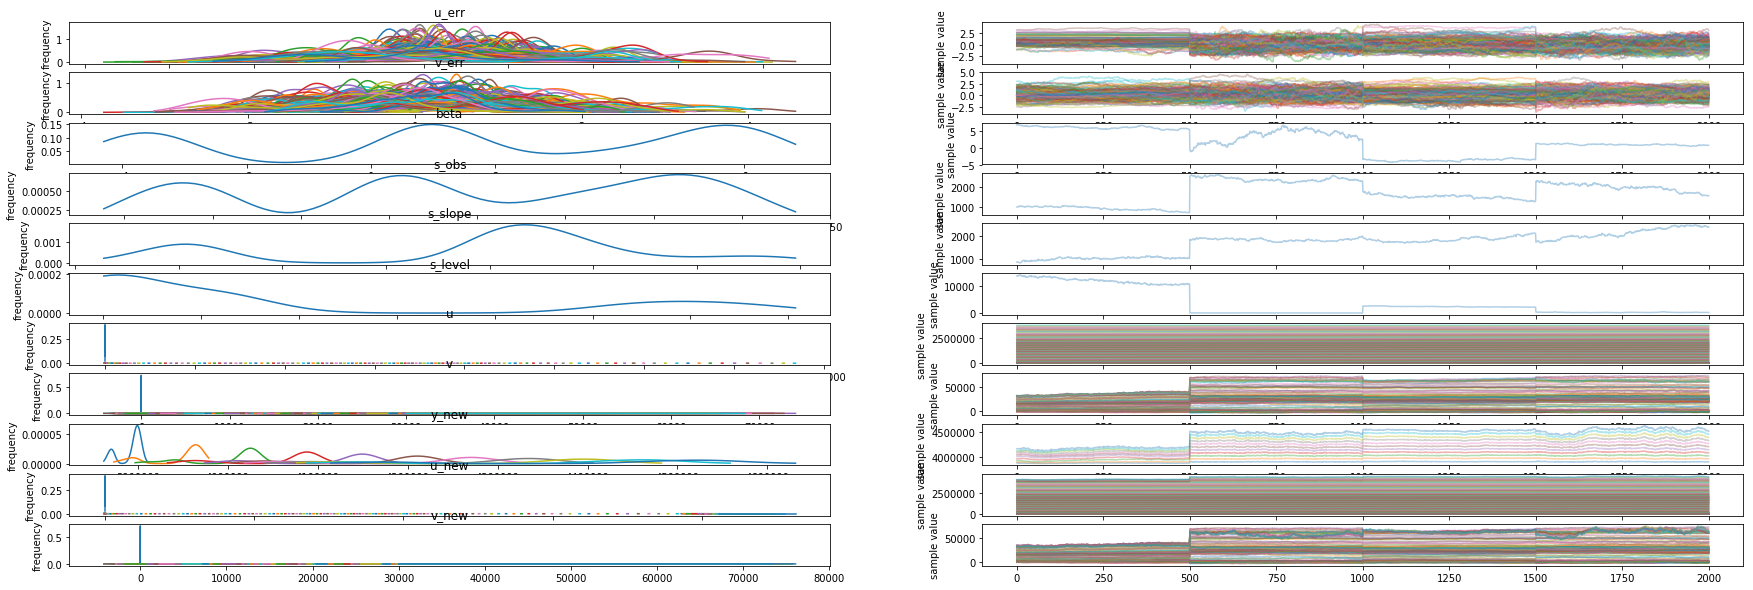

In [127]:
with mpl.rc_context():
    mpl.rc('figure', figsize=(30, 10))
    fit.plot()

In [128]:
samples = fit.extract(permuted=True)
u = samples['u'].mean(axis=0)
v = samples['v'].mean(axis=0)
u_new = samples['u_new'].mean(axis=0)
v_new = samples['v_new'].mean(axis=0)

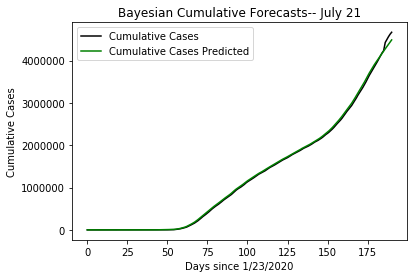

In [132]:
df['pred_new'] = u_new + v_new
plt.plot(list(range(len(df['Confirmed']))), df['Confirmed'], color="black", label="Cumulative Cases")
plt.plot(list(range(len(df['pred_new']))), df['pred_new'], color ="green", label ="Cumulative Cases Predicted")
plt.title("Bayesian Cumulative Forecasts-- July 21")
plt.xlabel("Days since 1/23/2020")
plt.ylabel("Cumulative Cases")
plt.legend()
plt.show()

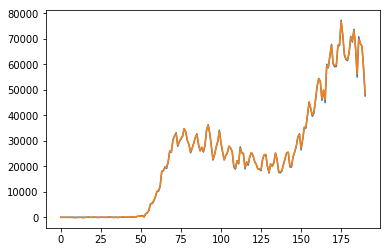

In [29]:
stan2 = '''data {
    int N;
    int pred_Num;
    vector[N] X;
}

parameters {
    vector[N] u;
    real<lower=0> s_u;
    real<lower=0> s_x;
}

model {
    u[2:N] ~ normal(u[1:(N-1)], s_u);
    X ~ normal(u, s_x);
}

generated quantities {
    vector[N + pred_Num] u_pred;
    vector[pred_Num] x_pred;
    u_pred[1:N] = u;
    for (i in 1:pred_Num) {
        u_pred[N+i] = normal_rng(u_pred[N+i-1], s_u);
        x_pred[i] = normal_rng(u_pred[N+i], s_x);
    }
}'''

In [30]:
data_feed = {'X': df['Daily'].head(170), 'N': 170, 'pred_Num': 191}
sm = pystan.StanModel(model_code=stan2)
fit = sm.sampling(data=data_feed, iter=1000)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e61e8e505b48c826607e12975d4b2863 NOW.


In [31]:
samples = fit.extract(permuted=True)
u_mean = samples['u_pred'].mean(axis=0)

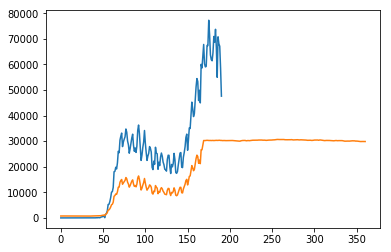

In [32]:
plt.plot(list(range(len(df['Daily']))), df['Daily'])
plt.plot(list(range(len(u_mean))), u_mean)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (100,) and (261,)

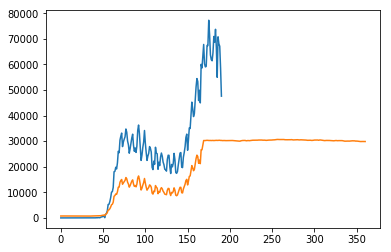

In [34]:
u_pred_1 = samples['u_pred'][0][100:]
u_pred_2 = samples['u_pred'][1][100:]
u_pred_3 = samples['u_pred'][2][100:]
u_pred_4 = samples['u_pred'][3][100:]

plt.plot(list(range(len(df['Daily']))), df['Daily'])
plt.plot(list(range(len(u_mean))), u_mean)
plt.plot(list(range(100, 200)), u_pred_1)
plt.plot(list(range(100, 200)), u_pred_2)
plt.plot(list(range(100, 200)), u_pred_3)
plt.plot(list(range(100, 200)), u_pred_4)
plt.show()

In [135]:
import glob
print(glob.glob("/home/adam/*.csv"))

TypeError: listdir() takes exactly 1 argument (0 given)